In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/11 23:48:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
data_loc = "../data/tables/"
consumer = spark.read.parquet(data_loc+"consumer_user_details.parquet")
tbl_consumer = spark.read.csv(data_loc+"tbl_consumer.csv", sep="|", header=True)
tbl_merchant = spark.read.parquet(data_loc+"tbl_merchants.parquet")
transact = spark.read.parquet(data_loc+"transactions_20210228_20210827_snapshot/")

<h2> 1. Standardize column format of tables</h2>

<h3>1.1 "tbl_merchants.parquet"</h3>

In [3]:
tbl_merchant.show(5)

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
+--------------------+--------------------+------------+
only showing top 5 rows



In [4]:
# separate "tags" into "products", "revenue_level", "take_rate"
preprocessed_tbl_merchant = tbl_merchant.withColumn("split_tags", split(col("tags"), ",")) \
            .withColumn("take_rate", element_at(col("split_tags"), -1)) \
            .withColumn("revenue_level", element_at(col("split_tags"), -2)) \
            .withColumn("products", slice(reverse(col("split_tags")), 3, 100)) \
            .withColumn("products", reverse(col("products")))


In [5]:
# remove the special characters of "revenue_level" and "take_rate"
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("revenue_level", regexp_replace("revenue_level", "[^a-e]", "")) \
                                                     .withColumn("take_rate", regexp_replace("take_rate", "[^0-9.]", ""))

In [6]:
# standardize the values in "products" and vectorize "products" into the bags of word
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("products", concat_ws(",", col("products"))) \
                                                     .withColumn("products", regexp_replace("products", "[^A-Za-z0-9]", " ")) \
                                                     .withColumn("products", regexp_replace("products", "\s+", " ")) \
                                                     .withColumn("products", regexp_replace("products", "(^\s+)|(\s+$)", "")) \
                                                     .withColumn("products", lower(col("products"))) \
                                                     .withColumn("products", split(col("products"), " "))

In [31]:
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumnRenamed("name", "merchant_name")
preprocessed_tbl_merchant = preprocessed_tbl_merchant.select("merchant_name", "products", "revenue_level",
                                                             preprocessed_tbl_merchant.take_rate.cast("double"), "merchant_abn")

In [32]:
preprocessed_tbl_merchant.show(5)

+--------------------+--------------------+-------------+---------+------------+
|       merchant_name|            products|revenue_level|take_rate|merchant_abn|
+--------------------+--------------------+-------------+---------+------------+
|       Felis Limited|[furniture, home,...|            e|     0.18| 10023283211|
|Arcu Ac Orci Corp...|[cable, satellite...|            b|     4.22| 10142254217|
|    Nunc Sed Company|[jewelry, watch, ...|            b|      4.4| 10165489824|
|Ultricies Digniss...|[watch, clock, an...|            b|     3.29| 10187291046|
| Enim Condimentum PC|[music, shops, mu...|            a|     6.33| 10192359162|
+--------------------+--------------------+-------------+---------+------------+
only showing top 5 rows



<h3>1.2 "transactions_20210228_20210827_snapshot"</h3>

In [9]:
transact.show(5)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



In [10]:
# separate pickup datetime into date, year, month and day
preprocessed_transact = transact.withColumn('order_year', year(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_month', month(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumn('order_day', dayofmonth(col('order_datetime')))
preprocessed_transact = preprocessed_transact.withColumnRenamed('merchant_abn', 'merchant_abn_repeat')

In [15]:
preprocessed_transact.show(5)

+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|user_id|merchant_abn_repeat|      dollar_value|            order_id|order_datetime|order_year|order_month|order_day|
+-------+-------------------+------------------+--------------------+--------------+----------+-----------+---------+
|  18478|        62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|      2021|          8|       20|
|      2|        15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|      2021|          8|       20|
|  18479|        64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|      2021|          8|       20|
|      3|        60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|      2021|          8|       20|
|  18479|        94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|      2021|          8|       20|
+-------+-------------------+------------------+--------

<h3>1.3 "tbl_consumer.csv"</h3>

In [16]:
tbl_consumer.show(5)

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
+-----------------+--------------------+-----+--------+------+-----------+
only showing top 5 rows



In [17]:
preprocessed_tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("address", "consumer_address")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("state", "consumer_state")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("postcode", "consumer_postcode")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("gender", "consumer_gender")

In [18]:
preprocessed_tbl_consumer.show(5)

+-----------------+--------------------+--------------+-----------------+---------------+-----------+
|         consumer|    consumer_address|consumer_state|consumer_postcode|consumer_gender|consumer_id|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
| Yolanda Williams|413 Haney Gardens...|            WA|             6935|         Female|    1195503|
|       Mary Smith|     3764 Amber Oval|           NSW|             2782|         Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|            NT|              862|         Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|           NSW|             2780|         Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|            WA|             6355|         Female|     712975|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
only showing top 5 rows



<h3>1.4 "consumer.parquet"</h3>

In [19]:
consumer.show(5)

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
+-------+-----------+
only showing top 5 rows



In [20]:
preprocessed_consumer = consumer.withColumnRenamed("user_id", "user_id_repeat")
preprocessed_consumer = preprocessed_consumer.withColumnRenamed("consumer_id", "consumer_id_repeat")

In [21]:
preprocessed_consumer.show(5)

+--------------+------------------+
|user_id_repeat|consumer_id_repeat|
+--------------+------------------+
|             1|           1195503|
|             2|            179208|
|             3|           1194530|
|             4|            154128|
|             5|            712975|
+--------------+------------------+
only showing top 5 rows



<h2>2. Join tables</h2>

In [68]:
preprocessed_tbl_merchant.createOrReplaceTempView('merchant')
preprocessed_transact.createOrReplaceTempView('transact')
preprocessed_tbl_consumer.createOrReplaceTempView('tbl_consumer')
preprocessed_consumer.createOrReplaceTempView('consumer')

join = spark.sql("""
SELECT 
    *
FROM 
    merchant
INNER JOIN
    transact
ON 
    transact.merchant_abn_repeat = merchant.merchant_abn
INNER JOIN
    consumer
ON
    transact.user_id = consumer.user_id_repeat
INNER JOIN
    tbl_consumer
ON 
    consumer.consumer_id_repeat = tbl_consumer.consumer_id
ORDER BY
    revenue_level DESC
""")

join = join.drop("merchant_abn_repeat", "consumer_id_repeat", "user_id_repeat", "merchant_abn", "consumer_id", "user_id", "order_id", "order_datetime")
print(f"Mismatched (null) transactions dropped: {preprocessed_transact.count() - join.count()}")

Mismatched (null) transactions dropped: 149228


In [23]:
join

merchant_name,products,revenue_level,take_rate,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender
Eros Industries,"[computer, progra...",e,0.41,325.21981277272863,2021,8,9,John Jennings,6323 Warner Field...,NSW,1235,Male
Feugiat Nec Diam LLC,"[computers, compu...",e,0.30,13.989035438501453,2021,7,10,Jerry Howell,98491 Jones Spurs,QLD,4272,Undisclosed
Augue Eu Tempor A...,"[cable, satellite...",e,0.38,156.2370489731108,2021,5,11,John Jennings,6323 Warner Field...,NSW,1235,Male
Et Nunc Consulting,"[books, periodica...",e,0.16,216.59526746423708,2021,7,30,John Jennings,6323 Warner Field...,NSW,1235,Male
Hendrerit Donec L...,"[digital, goods, ...",e,0.18,45.2833743597625,2021,4,2,John Jennings,6323 Warner Field...,NSW,1235,Male
Felis Limited,"[furniture, home,...",e,0.18,351.2871670330808,2021,5,31,Christopher Powell,880 Brandon Stree...,NT,852,Undisclosed
Et Nunc Consulting,"[books, periodica...",e,0.16,43.05799394172801,2021,3,5,John Jennings,6323 Warner Field...,NSW,1235,Male
Augue Eu Tempor A...,"[cable, satellite...",e,0.38,145.74710817228924,2021,5,1,Thomas Flowers,06874 Lee Expressway,VIC,3013,Undisclosed
Augue Eu Tempor A...,"[cable, satellite...",e,0.38,71.32944241273363,2021,6,17,Benjamin Olson,5707 Bryan Port,VIC,3727,Male
Lacus Mauris Asso...,"[shoe, shops]",e,0.48,123.51425898726025,2021,5,26,Alejandro Robinson,70252 Tapia Hollow,QLD,4076,Male


<h2>3. Outlier removal</h2>

<h3>3.1 Get distribution for each revenue level</h3>

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

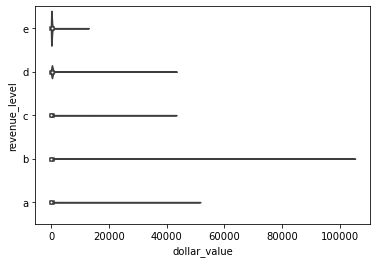

In [40]:
import seaborn as sns
sns.violinplot(data=join.toPandas(), x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

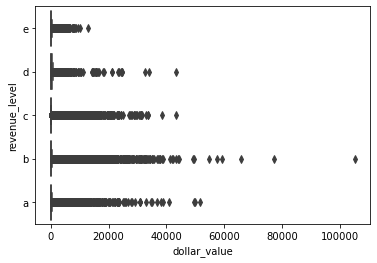

In [46]:
sns.boxplot(data=join.toPandas(), x="dollar_value", y="revenue_level")

<h4>3.1.1 Remove outliers based on standard deviation</h4>

In [53]:
rev_std = (join.groupBy("revenue_level").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                             avg("dollar_value").alias("dollar_value_mean")))
rev_std

revenue_level,dollar_value_std,dollar_value_mean
e,398.09440992860766,205.07215671809263
d,752.4097865676849,277.9027482625898
c,424.10764099241806,136.19036030606617
b,615.8068621019021,197.57629518633377
a,358.29739943649037,142.21571410099912


In [54]:
total = join.count()
rev_sdf = (join.join(rev_std, "revenue_level", "left")
               .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
               .drop("dollar_value_mean")
               .drop("dollar_value_std"))
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

Outliers based on revenue band removed: 34981


<h4>3.1.2 Check distribution</h4>

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

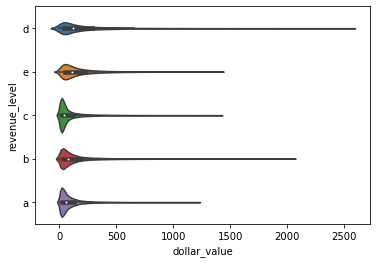

In [55]:
sns.violinplot(data=rev_sdf.toPandas(), x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

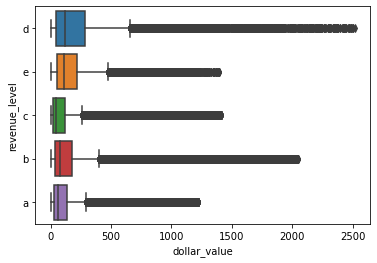

In [56]:
sns.boxplot(data=rev_sdf.toPandas(), x="dollar_value", y="revenue_level")

<h3>3.2 Get distribution of each merchant</h3>

In [65]:
merch_std = (rev_sdf.groupBy("merchant_name").agg(stddev_pop("dollar_value").alias("dollar_value_std"),
                                                  avg("dollar_value").alias("dollar_value_mean")))
merch_std

merchant_name,dollar_value_std,dollar_value_mean
Donec Luctus Indu...,132.34433909880525,345.84335391960195
Elit Company,110.51547112044194,164.8865673081395
Aliquet Odio Ltd,468.81972000533193,811.0558897360265
Et Pede Inc.,409.8569331778463,725.9647254722089
Commodo Auctor Ve...,50.84746226067416,59.367369142167334
Hendrerit Consect...,308.63364411302115,316.30998860156814
Libero Nec Ligula...,358.50312145773313,786.1461373031286
Montes Nascetur Ltd,208.28039909197162,377.3328664254842
Ut Nisi Limited,517.218201317942,665.7171729461087
Enim Etiam Institute,308.60007817038104,599.6580339255797


In [67]:
total = rev_sdf.count()
merch_sdf = (rev_sdf.join(merch_std, "merchant_name", "left")
                   .filter(abs(col("dollar_value") - col("dollar_value_mean")) <= 3 * col("dollar_value_std"))
                   .drop("dollar_value_mean")
                   .drop("dollar_value_std"))
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

Outliers based on merchant removed: 44816


In [69]:
merch_sdf.write.parquet("../data/curated/mechant_consumer_info")